In [2]:
!pip install torchmetrics
!pip install pretrained-backbones-unet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import torchvision.transforms.functional as F
from tqdm import tqdm  # for progress bars
from backbones_unet.model.unet import Unet
from torchvision.transforms import InterpolationMode
import random

In [ ]:
# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
########################################
# Network and Training Parameters      #
########################################
IMG_SIZE = 128
NBEPOCHS = 200
BATCH_SIZE = 64
NBPATIENCE_EPOCHS = 5
NUM_CLASSES = 4  # Assuming 3 classes as confirmed

train_images_path = "/content/drive/MyDrive/SBE_GP/camus-hands-on/dataset/segmentation/train/images/"
train_masks_path = "/content/drive/MyDrive/SBE_GP/camus-hands-on/dataset/segmentation/train/labels/"
valid_images_path = "/content/drive/MyDrive/SBE_GP/camus-hands-on/dataset/segmentation/valid/images/"
valid_masks_path = "/content/drive/MyDrive/SBE_GP/camus-hands-on/dataset/segmentation/valid/labels/"
test_images_path = "/content/drive/MyDrive/SBE_GP/camus-hands-on/dataset/segmentation/test/images/"
test_masks_path = "/content/drive/MyDrive/SBE_GP/camus-hands-on/dataset/segmentation/test/labels/"

model_path = 'trained_model/'
os.makedirs(model_path, exist_ok=True)

In [ ]:

########################################
# Custom Dual Transform                #
########################################
cudnn.benchmark = True

class DualTransform:
    def __init__(self, img_size=128, angle=5, translate=(0.05, 0.05), scale=(0.8, 1.2), fill=0, augment=True):
        self.img_size = img_size
        self.angle = angle
        self.translate = translate
        self.scale = scale
        self.fill = fill
        self.augment = augment

    def __call__(self, image, mask):
        image = F.resize(image, (self.img_size, self.img_size), interpolation=InterpolationMode.BILINEAR)
        mask = F.resize(mask, (self.img_size, self.img_size), interpolation=InterpolationMode.NEAREST)

        if self.augment:
            angle = random.uniform(-self.angle, self.angle)
            max_dx = self.translate[0] * self.img_size
            max_dy = self.translate[1] * self.img_size
            translations = (random.uniform(-max_dx, max_dx), random.uniform(-max_dy, max_dy))
            scale_factor = random.uniform(self.scale[0], self.scale[1])
            shear = 0.0

            image = F.affine(image, angle=angle, translate=translations, scale=scale_factor, shear=shear, fill=self.fill)
            mask = F.affine(mask, angle=angle, translate=translations, scale=scale_factor, shear=shear, fill=0)

        image = F.to_tensor(image)
        image = F.normalize(image, mean=[0.5], std=[0.5])

        mask = np.array(mask, dtype=np.int64)
        mask = torch.from_numpy(mask)
        mask = self.remap_mask(mask)

        return image, mask

    @staticmethod
    def remap_mask(mask):
        remapped = torch.zeros_like(mask)
        remapped[mask == 0] = 0
        remapped[mask == 85] = 1
        remapped[mask == 170] = 2
        remapped[mask == 255] = 3
        return remapped

In [ ]:
########################################
# Dataset                              #
########################################
class CAMUSDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        assert len(self.images) == len(self.masks), "Number of images and masks must be the same."

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform:
            image, mask = self.transform(image, mask)
        return image, mask

In [ ]:
########################################
# Dataloaders                          #
########################################
train_transform = DualTransform(img_size=IMG_SIZE, angle=5, translate=(0.05,0.05), scale=(0.8,1.2), augment=True)
valid_transform = DualTransform(img_size=IMG_SIZE, angle=0, translate=(0,0), scale=(1,1), augment=False)
test_transform = DualTransform(img_size=IMG_SIZE, angle=0, translate=(0,0), scale=(1,1), augment=False)

train_dataset = CAMUSDataset(train_images_path, train_masks_path, transform=train_transform)
valid_dataset = CAMUSDataset(valid_images_path, valid_masks_path, transform=valid_transform)
test_dataset = CAMUSDataset(test_images_path, test_masks_path, transform=test_transform)

# Reduce number of workers as suggested
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
########################################
# Model Initialization                 #
########################################
model = Unet(
    backbone='convnext_base',
    in_channels=3,
    num_classes=NUM_CLASSES
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
########################################
# Multi-class Dice Loss                #
########################################
class MultiClassDiceLoss(nn.Module):
    def __init__(self, from_logits=True, eps=1e-6):
        super().__init__()
        self.from_logits = from_logits
        self.eps = eps

    def forward(self, y_pred, y_true):
        if self.from_logits:
            y_pred = torch.softmax(y_pred, dim=1)

        B, C, H, W = y_pred.shape
        dice_loss = 0.0
        for c in range(C):
            y_true_c = (y_true == c).float()
            y_pred_c = y_pred[:, c, :, :]
            intersection = (y_pred_c * y_true_c).sum(dim=(1,2))
            union = y_pred_c.sum(dim=(1,2)) + y_true_c.sum(dim=(1,2))
            dice_c = (2.0 * intersection + self.eps) / (union + self.eps)
            dice_loss += (1 - dice_c.mean())
        return dice_loss / C

criterion = MultiClassDiceLoss(from_logits=True)

In [ ]:
########################################
# IoU Calculation                      #
########################################
def compute_iou(pred, target, num_classes=NUM_CLASSES):
    ious = []
    for c in range(num_classes):
        pred_c = (pred == c)
        target_c = (target == c)
        intersection = (pred_c & target_c).sum().item()
        union = (pred_c | target_c).sum().item()
        if union > 0:
            ious.append(intersection / (union + 1e-6))
    if len(ious) == 0:
        return 1.0
    return sum(ious) / len(ious)

# Use torch.amp instead of torch.cuda.amp as per future warning
scaler = torch.amp.GradScaler()

In [ ]:
########################################
# Training & Validation Functions      #
########################################
def train(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    epoch_iou = 0.0
    with tqdm(total=len(loader), desc='Training') as pbar:
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(outputs, dim=1)
            batch_iou = compute_iou(preds, masks, num_classes=NUM_CLASSES)

            epoch_loss += loss.item()
            epoch_iou += batch_iou
            pbar.update(1)

    return epoch_loss / len(loader), epoch_iou / len(loader)

In [ ]:
def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    with torch.no_grad():
        with tqdm(total=len(loader), desc='Validation') as pbar:
            for images, masks in loader:
                images, masks = images.to(device), masks.to(device)
                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                preds = torch.argmax(outputs, dim=1)
                batch_iou = compute_iou(preds, masks, num_classes=NUM_CLASSES)
                val_loss += loss.item()
                val_iou += batch_iou
                pbar.update(1)

    return val_loss / len(loader), val_iou / len(loader)

In [ ]:
########################################
# Training Loop                        #
########################################
best_val_loss = float('inf')
patience = 0

for epoch in range(NBEPOCHS):
    print(f"Epoch {epoch+1}/{NBEPOCHS}")
    train_loss, train_iou = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_iou = validate(model, valid_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), os.path.join(model_path, "best_model.pth"))
        print("Model saved!")
    else:
        patience += 1
        if patience >= NBPATIENCE_EPOCHS:
            print("Early stopping triggered!")
            break


Epoch 1/200


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Train Loss: 0.7647, Train IoU: 0.1740
Val Loss: 0.7168, Val IoU: 0.1871
Model saved!
Epoch 2/200


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Train Loss: 0.6505, Train IoU: 0.3699
Val Loss: 0.6067, Val IoU: 0.4076
Model saved!
Epoch 3/200


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Train Loss: 0.5858, Train IoU: 0.5110
Val Loss: 0.5507, Val IoU: 0.5426
Model saved!
Epoch 4/200


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Train Loss: 0.5522, Train IoU: 0.5772
Val Loss: 0.5166, Val IoU: 0.5816
Model saved!
Epoch 5/200


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Train Loss: 0.5297, Train IoU: 0.6135
Val Loss: 0.5177, Val IoU: 0.6162
Epoch 6/200


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Train Loss: 0.5199, Train IoU: 0.6342
Val Loss: 0.5014, Val IoU: 0.6493
Model saved!
Epoch 7/200


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Train Loss: 0.5048, Train IoU: 0.6537
Val Loss: 0.4927, Val IoU: 0.6752
Model saved!
Epoch 8/200


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Train Loss: 0.4942, Train IoU: 0.6710
Val Loss: 0.4853, Val IoU: 0.6694
Model saved!
Epoch 9/200


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Train Loss: 0.4867, Train IoU: 0.6814
Val Loss: 0.4779, Val IoU: 0.6947
Model saved!
Epoch 10/200


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Train Loss: 0.4809, Train IoU: 0.6977
Val Loss: 0.4698, Val IoU: 0.6905
Model saved!
Epoch 11/200


Training:   0%|          | 0/13 [00:00<?, ?it/s]

<ipython-input-3-242cb4ddcb38>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=dev


Test Results:
Loss: 0.1718, IoU: 0.8537, Dice: 0.9169



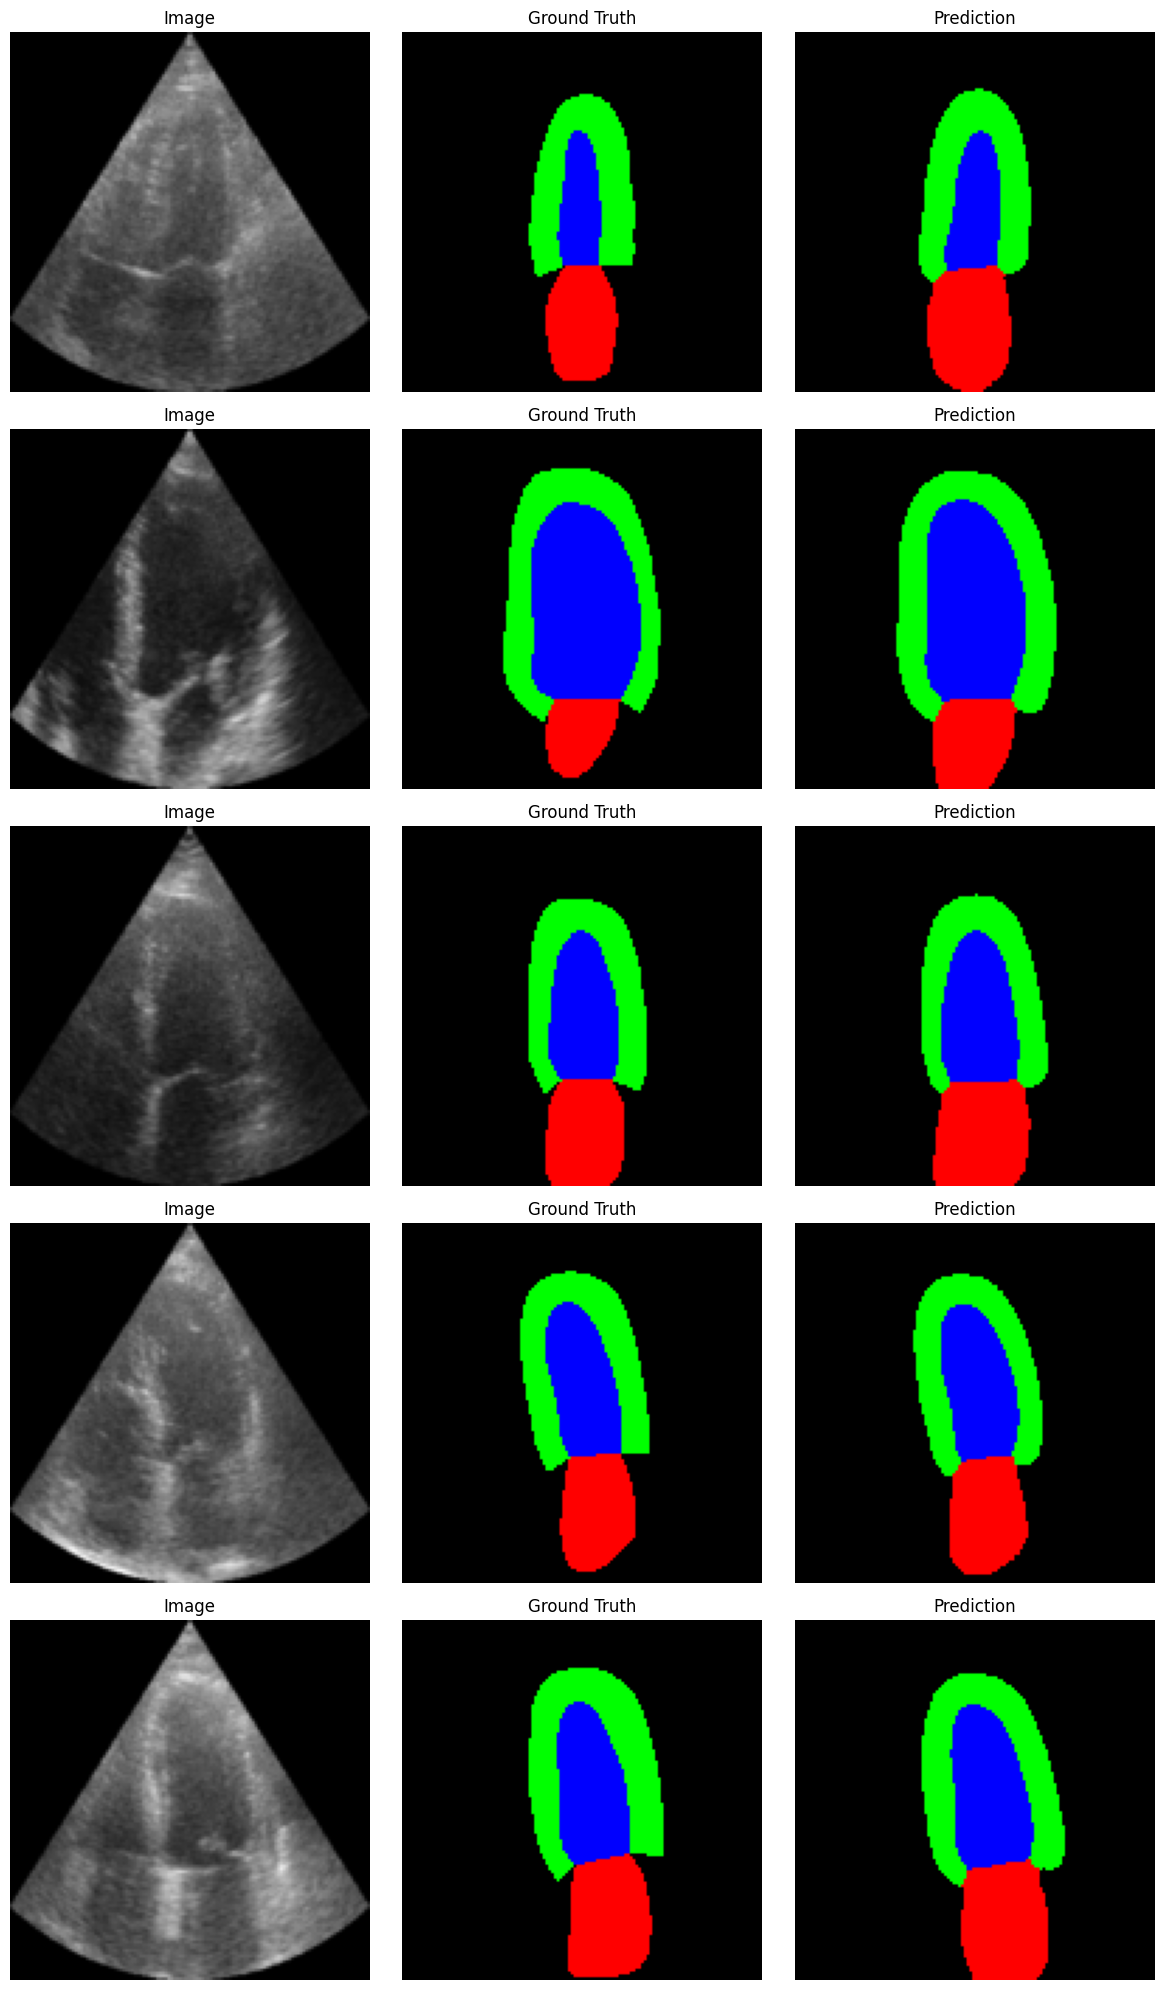

In [3]:
########################################
# Load Best Model and Evaluate on Test #
########################################

# Load the best model weights
model.load_state_dict(torch.load(os.path.join(model_path, "best_model.pth"), map_location=device))
model.eval()

# Compute Test Loss, IoU, and Dice
test_loss = 0.0
test_iou = 0.0
test_dice = 0.0
num_batches = 0

def compute_dice_multiclass(pred, target, num_classes):
    """Compute Dice score for multi-class predictions."""
    dice_scores = []
    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()
        intersection = (pred_c * target_c).sum().item()
        dice_c = (2.0 * intersection) / (pred_c.sum().item() + target_c.sum().item() + 1e-6)
        dice_scores.append(dice_c)
    return sum(dice_scores) / len(dice_scores)

def compute_iou_multiclass(pred, target, num_classes):
    """Compute IoU for multi-class predictions."""
    iou_scores = []
    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()
        intersection = (pred_c * target_c).sum().item()
        union = (pred_c + target_c).clamp(0, 1).sum().item()
        iou_c = intersection / (union + 1e-6)
        iou_scores.append(iou_c)
    return sum(iou_scores) / len(iou_scores)

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)  # Shape: BxCxHxW
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)  # Convert logits to class indices
        batch_iou = 0.0
        batch_dice = 0.0

        for i in range(images.size(0)):
            batch_iou += compute_iou_multiclass(preds[i], masks[i], NUM_CLASSES)
            batch_dice += compute_dice_multiclass(preds[i], masks[i], NUM_CLASSES)

        batch_iou /= images.size(0)
        batch_dice /= images.size(0)

        test_iou += batch_iou
        test_dice += batch_dice
        num_batches += 1

test_loss /= num_batches
test_iou /= num_batches
test_dice /= num_batches

print("\nTest Results:")
print(f"Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, Dice: {test_dice:.4f}\n")

########################################
# Visualization of Predictions         #
########################################
import matplotlib.pyplot as plt
import random
import numpy as np

# Define a colormap for the classes
class_colors = {
    0: [0, 0, 0],       # Background (black)
    1: [255, 0, 0],     # Class 1 (red)
    2: [0, 255, 0],     # Class 2 (green)
    3: [0, 0, 255],     # Class 3 (blue)
}

def colorize_mask(mask, class_colors):
    """Convert a mask to RGB using the defined colormap."""
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for c, color in class_colors.items():
        mask_rgb[mask == c] = color
    return mask_rgb

# Select 5 random images from the test dataset
indices = random.sample(range(len(test_dataset)), 5)

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 20))
model.eval()
for row, idx in enumerate(indices):
    image, mask = test_dataset[idx]
    image_batch = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_batch)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Convert image back to numpy for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5) + 0.5  # De-normalize
    image_np = np.clip(image_np, 0, 1)

    mask_np = mask.squeeze().cpu().numpy()
    pred_np = pred

    # Convert masks to RGB
    mask_rgb = colorize_mask(mask_np, class_colors)
    pred_rgb = colorize_mask(pred_np, class_colors)

    axs[row, 0].imshow(image_np)
    axs[row, 0].set_title("Image")
    axs[row, 0].axis('off')

    axs[row, 1].imshow(mask_rgb)
    axs[row, 1].set_title("Ground Truth")
    axs[row, 1].axis('off')

    axs[row, 2].imshow(pred_rgb)
    axs[row, 2].set_title("Prediction")
    axs[row, 2].axis('off')

plt.tight_layout()
plt.show()
